## Generate the mesh

In [2]:
from mesh import three_cubes
from convert_mesh import convert_mesh

size = 0.05
three_cubes(f"meshes/mesh_{size}.msh", size=size)

volume_file = f"meshes/mesh_{size}.xdmf"
facet_file = f"meshes/mesh_{size}_facet.xdmf"
nb_cells, nb_facets = convert_mesh(f"meshes/mesh_{size}.msh", volume_file, facet_file)

Info    : Meshing 1D...nts                                                                                                             
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 60%] Meshing curve 17 (Line)
Info    : [ 70%] Meshing curve 18 (Line)
Info    : [ 70%] Meshing curve 19 (Line)
Info    : [ 70%] Meshing curve 20 (Line)
Info    : [ 80%] Meshing curve 21 (Line)
Info    : [ 

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


-------------------------------------------------------
Version       : 4.13.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20241016
Build host    : 2976249cf102
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blossom Cairo DIntegration Dlopen DomHex Eigen[contrib] Fltk GMP Gmm[contrib] Hxt Jpeg Kbipack LinuxJoystick MathEx[contrib] Mesh Metis[contrib] Mpeg Netgen Nii2mesh ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR TinyXML2[contrib] Untangle Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.3.9
OCC version   : 7.8.1
Packaged by   : conda
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------

Surface IDs:  [4 5 6 7]
Volume IDs:  [1 2 3]


In [3]:
def run(volume_file: str, facet_file: str) -> float:
    from script_festim_2 import run_festim_2
    import time

    start = time.perf_counter()
    run_festim_2(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time

In [4]:
import ipyparallel as ipp
import numpy as np


num_procs = [1, 2, 4, 8, 16]
runtimes = np.zeros_like(num_procs, dtype=np.float64)

for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")

    # start an ipyparallel cluster and connect to it
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    # run the function run in parallel
    query = rc[:].apply_async(run, volume_file, facet_file)
    query.wait()

    # get the results for all processes
    elapsed_times = query.get()
    print(elapsed_times)

    # get the maximum runtime
    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes[i] = runtime

Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.47s/engine]
[21.844400390000004]
Elapsed times: [21.844400390000004] seconds, max runtime=2.18e+01
Running with 2 processes
Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.75s/engine]
[15.849278886000008, 15.848211511000002]
Elapsed times: [15.849278886000008, 15.848211511000002] seconds, max runtime=1.58e+01
Running with 4 processes
Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.38s/engine]
[12.863444683999987, 12.863349031000013, 12.862797056999995, 12.862865822000003]
Elapsed times: [12.863444683999987, 12.863349031000013, 12.862797056999995, 12.862865822000003] seconds, max runtime=1.29e+01
Running with 8 processes
Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLaun

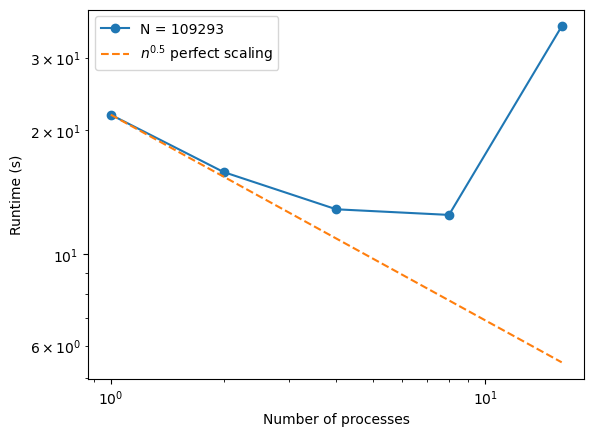

In [13]:
import matplotlib.pyplot as plt

plt.plot(num_procs, runtimes, marker="o", label=f"N = {nb_cells}")

n = np.linspace(1, 16, 100)
plt.plot(n, runtimes[0] * n**-0.5, linestyle="--", label="$n^{-0.5}$ (perfect scaling)")

plt.xlabel("Number of processes $n$")
plt.ylabel("Runtime (s)")

plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.show()